In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import georaster as gr
import imageio
from IPython.display import clear_output

In [2]:
sns.set_theme()

## Load data

In [3]:
data = pd.read_csv('data/starships_clean.csv', index_col='id', parse_dates=['date'])

## Explore counts

In [4]:
data

,ship_type,date,lon,lat
id,,,,
1,TIE Fighter,2018-05-07 12:00:00,-19.950145,27.552059
2,TIE bomber,2018-05-07 12:00:00,-19.925915,27.527897
3,TIE bomber,2018-05-07 12:00:00,-19.927374,27.527464
4,TIE Fighter,2018-05-07 12:00:00,-19.915460,27.516342
5,TIE Fighter,2018-05-07 12:00:00,-19.948334,27.557954
...,...,...,...,...
3459,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.916284,27.515434
2524742,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.949415,27.550263
2524752,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.948473,27.550805


### Inspect id

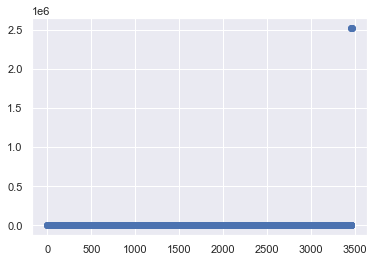

In [5]:
# Is id continuous?
plt.scatter(range(len(data.index)), data.index)

- There seems to have an outlier in the end of the series
- Id seems continuous (without the outlier)

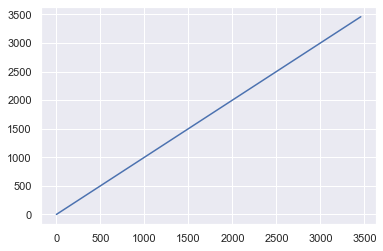

In [6]:
# (temprorarilly) Remove the outliers to zoom on the remaining ids
plt.plot(range(len(data.index[:-4])), data.index[:-4])

Analysis:
- Ids indeed seem continuous

Questions:
- Is there a meaning in the id? -> **YES**
- Is the id correlated with:
    - the type of starship?
    - the time (linear) -> **YES** (see eda_cleaning)
    - the year period (cyclical)

### Inspect date

Text(0, 0.5, 'Count')

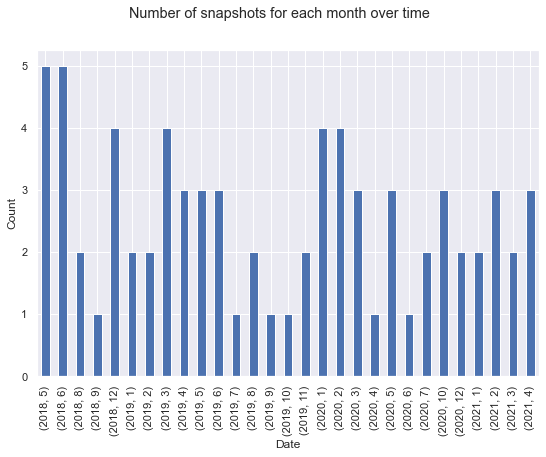

In [7]:
# Number of snapshots per month
s = data['date'].apply(lambda x: x.date())
s = pd.Series(s.unique())
g = s.groupby([s.apply(lambda x: x.year), s.apply(lambda x: x.month)]).count()
plt.figure(figsize=(9, 6))
g.plot.bar()
plt.suptitle('Number of snapshots for each month over time')
plt.xlabel('Date')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

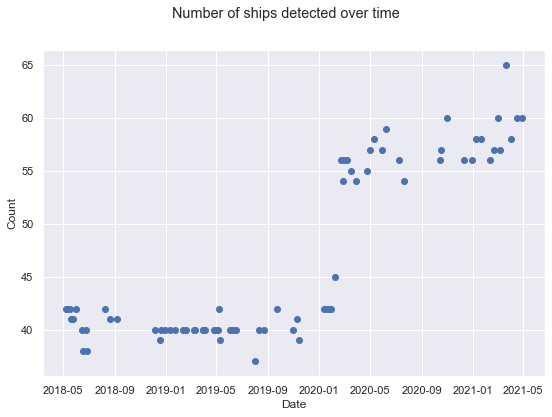

In [8]:
plt.figure(figsize=(9, 6))
date_counts = data['date'].value_counts()
plt.scatter(date_counts.index, date_counts.values)
plt.suptitle('Number of ships detected over time')
plt.xlabel('Date')
plt.ylabel('Count')

Analysis:
- There is a clear event at ±2020-02, with + half ships
- before 2020-02: number of ships within 38-42
- after 2020-02: number of ships within 54-60
- Seems like an outlier with 65 ships in ±2021-03

Questions:
- Was there a diminution / rupture of a certain type of ship before the event?
- What is the repartition of new ships?
    - if it is a general augmentation (for all types), it shouldn't be a diminution of one type of ship only
    - was it a progressive or a brutal diminution of ships?

#### Test hyp: more data points during estival period, fewer during winter (because ships are hidden in their boxes)

- Rather seems like there are no boxes

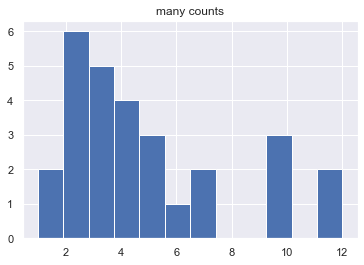

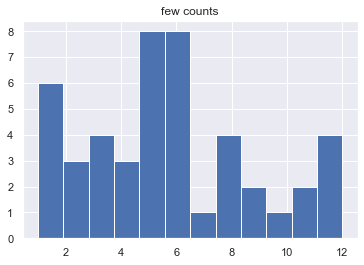

In [9]:
COUNT_LIMIT = 50

counts_by_date = data.groupby('date').count()
ma_many_ships = counts_by_date['ship_type'] > COUNT_LIMIT
months_many = counts_by_date[ma_many_ships].index.month
plt.hist(months_many, bins=12)
plt.title('many counts')
plt.show()

ma_few_ships = counts_by_date['ship_type'] < COUNT_LIMIT
months_few = counts_by_date[ma_few_ships].index.month
plt.hist(months_few, bins=12)
plt.title('few counts')
plt.show()

- There is no clear pattern. It is not correlated with specific months as expected

#### Test hyp: many data points during the week, fewer during week-end (because ships are hidden in their boxes)

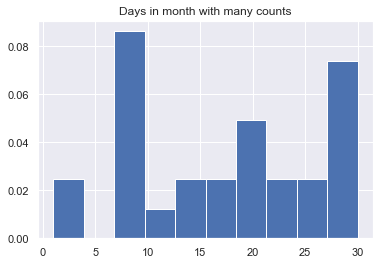

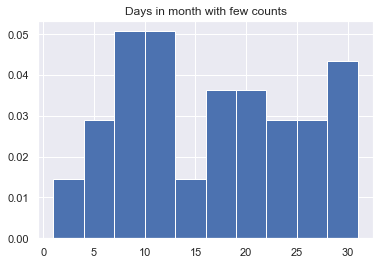

In [10]:
COUNT_LIMIT = 50

day_many = counts_by_date[ma_many_ships].index.day
plt.hist(day_many, density=True)
plt.title('Days in month with many counts')
plt.show()

day_few = counts_by_date[ma_few_ships].index.day
plt.hist(day_few, density=True)
plt.title('Days in month with few counts')
plt.show()

- There seems to have a slight increase around 10, 20 and 30
- SImilarily, there seems to have a slight decrease around 1 and 15
- These should be tested for their significance (might be random noise)

In [11]:
print(day_many)
print(day_few)

Int64Index([22, 25, 28,  7, 15, 27, 22,  1,  9, 30,  7,  9, 21, 13, 16, 30,  9,
            29,  7, 19, 10, 20, 28,  7, 20,  2, 16, 28],
           dtype='int64', name='date')
Int64Index([ 7, 11, 16, 19, 24,  1, 15, 18, 23, 26,  9, 20,  7,  6, 17, 19, 30,
            10, 21,  9, 17,  8, 11, 29, 30,  4, 25, 27,  4,  8, 10,  3, 10, 16,
            31, 10, 23, 22, 30,  8, 14, 11, 19, 26, 29,  6],
           dtype='int64', name='date')


### Investigate ship_type

#### Ship_type repartition

TIE Fighter              2034
Imperial SpaceShuttle     827
TIE bomber                511
Civilian Star Shuttle      89
Surveillance droid          2
Name: ship_type, dtype: int64


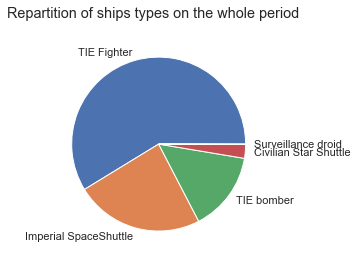

In [12]:
# Total period
ship_type_total = data['ship_type'].value_counts()
ship_type_total.plot.pie(label="")
plt.suptitle('Repartition of ships types on the whole period')
print(ship_type_total)

In [13]:
# Get extreme dates
date_first = data['date'].min()
date_last = data['date'].max()

# Masks
ma_snap_first = data['date'] == date_first
ma_snap_last = data['date'] == date_last

# Extract ship_type for the given dates
ship_type_first = data[ma_snap_first]['ship_type'].value_counts()
ship_type_last = data[ma_snap_last]['ship_type'].value_counts()

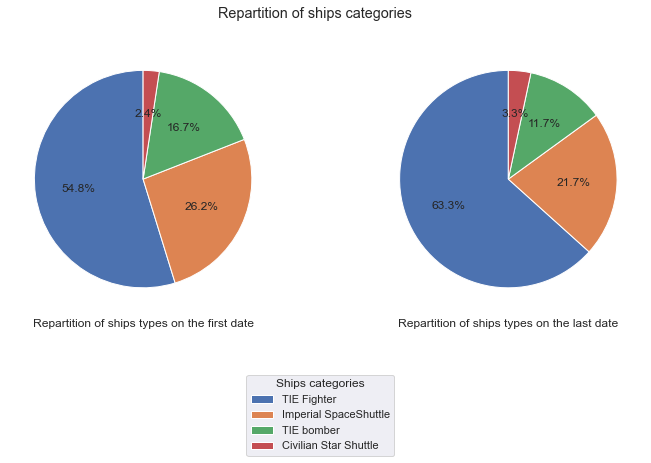

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Repartition of ships categories')
axs[0].pie(ship_type_first, autopct='%1.1f%%', startangle=90)
axs[0].set_xlabel('Repartition of ships types on the first date')
axs[1].pie(ship_type_last, autopct='%1.1f%%', startangle=90)
axs[1].set_xlabel('Repartition of ships types on the last date')
plt.legend(ship_type_first.index, title='Ships categories', bbox_to_anchor=(-.4, -1.2, 0.5, 1))

#### Evolution of each ship_type

TODO: study the correlation between the categories
(if noise, some category might be higher when another is lower because of errors in the recognition of the ship type by the CV algorithm)

Text(0.5, 0.98, 'Evolution of spaceships count by category')

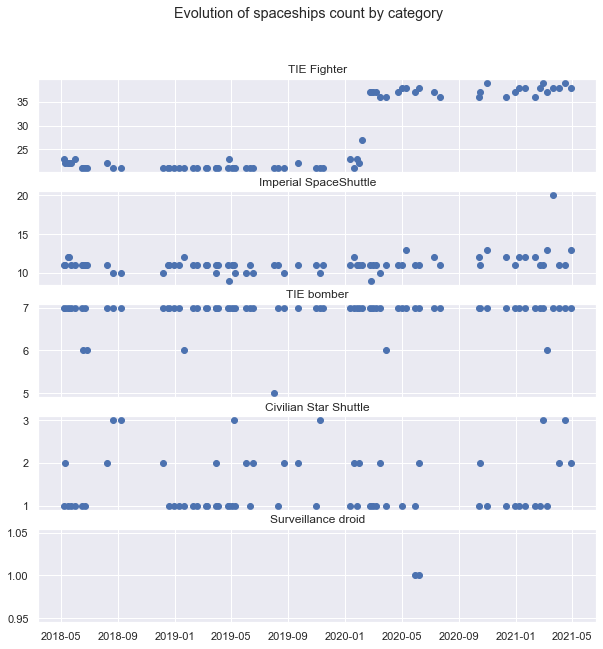

In [15]:
# Get the count of a ship_type for each date
series_by_type = []
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
for i, ship_type in enumerate(data['ship_type'].value_counts().index):
    ma_ship_type = data['ship_type'] == ship_type
    evol_count = data[ma_ship_type].groupby('date').count()['ship_type']
    axs[i].scatter(evol_count.index, evol_count)
    axs[i].set_title(ship_type)

plt.suptitle('Evolution of spaceships count by category')

#### We suspect some vehicles might have been decommissioned and remain static. Could this information be confirmed by the detections ?
-> **YES**: each type of ship has a fluctuating count that could be explained by **decommissioned** ships on a more or less frequent basis

- Surveillance droid:
    - only 2 points, could be due to:
        - noise: the CV detection algorithm made a mistake
        - hidden: since its a droid, it is never left outside so it is improbable to detect it? (only by chance)
        - Its not their droid! (it has been there only two weeks)
    - otherwise constant over time


- Civilian star shuttle:
    - 3 modes [1, 2, 3] might be due to:
        - noise
        - some might be **decommissioned**: there seems to have a periodic pattern
    - Most often 1:
        - The remaining might often be hidden
    - otherwise constant over time


- TIE Bomber:
    - 3 modes [5, 6, 7]
    - Very often 7
    - 6 on a cyclical basis, might be **decommissionned** sometimes
    - otherwise constant over time


- Imperial SpaceShuttle:
    - very slight increase over time:
        - [10-12] before 2020-02
        - [11-13] after
    - might be a cyclical pattern going down and up again:
        - might be pure noise
        - might be solid, potentially because of **decommissionned** ships
    - Clear outlier when at 20 (once)


- TIE Fighter:
    - hugh increase over time:
        - [20-23] before event
        - [36-39] after event
        - has seen the highest increase (and single very significative)
        - the variations might be due to:
            - pure noise
            - potential **decommissionned** of ships

#### Is there any meaningful trend or rare events that could help understand the evolution of this installation ? How would you develop an automatic alerting system to detect such anomalies ?
-> **YES**: there is a huge brutal augmentation of TIE Fighters count in ±2020-03.

#### Other
- There are no observations within [2018-09-2018-12] and [2020-08-2020-12] for all the ship_types (due to winter?)

## Explore positions
- Are there any re-organization of the space? e.g. ship_type moved to another place?

### High activity areas (presence)

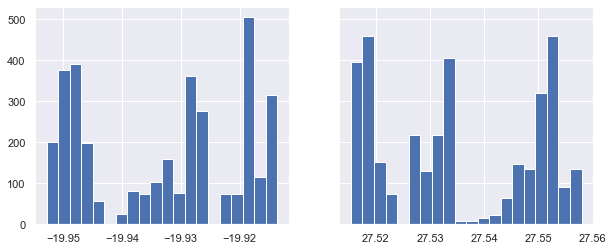

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
counts_lon, bins_lon, _ = axs[0].hist(data['lon'], bins=20)
counts_lat, bins_lat, _ = axs[1].hist(data['lat'], bins=20)
plt.show()

- There seem to have 3 favored places
    - in the *longitude* axis, around:
        - -19.95
        - -19.928
        - -19.918
    - in the *latitude* axis, which might be parking garages, around:
        - 27.52
        - 27.532
        - 27.55

In [17]:
N_CENTROIDS = 4  # 4 because there are a lot of them in a same place (see left)

modes_lon = pd.DataFrame({'counts':counts_lon, 'bins':bins_lon[:-1]})
modes_lat = pd.DataFrame({'counts':counts_lat, 'bins':bins_lat[:-1]})

x_centroids = modes_lon.sort_values('counts', ascending=False)[:N_CENTROIDS]['bins'].values
y_centroids = modes_lat.sort_values('counts', ascending=False)[:N_CENTROIDS]['bins'].values

Construct the background image

In [18]:
raster_name = 'data/space_port_image.tif'
raster = gr.MultiBandRaster(raster_name)

# Boundaries
x_min, x_max, y_min, y_max = raster.extent
raster.extent

(-20.0, -19.8627102, 27.4990877, 27.5701161)

In [19]:
# Average all 3 background image layers
img_arr = raster.r.mean(axis=2)

Construct ship type color correspondance table

In [20]:
ship_types = data['ship_type'].unique()
ship_types.sort()

In [21]:
# Construct color scale
color_scale = ['#7A5E1B', '#229954', '#F4D03F', '#193F7D', '#C0392B']
# Construct color-ship correspondance table
ship_color_table = {ship:color for (ship, color) in zip(ship_types, color_scale)}

Draw the plot

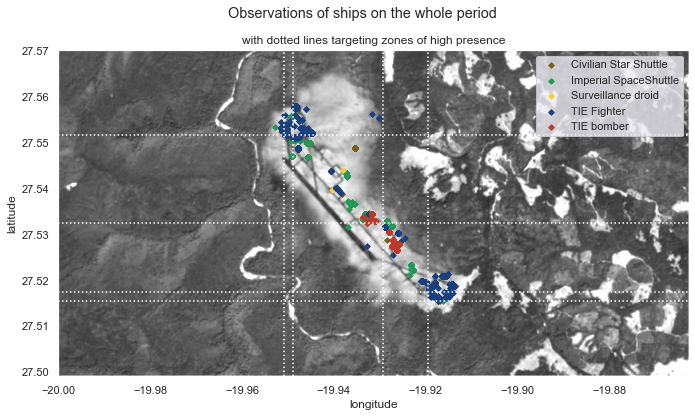

In [22]:
plt.figure(figsize=(12, 6))

# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

for ship, color in ship_color_table.items():
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=15, marker='D', label=ship)

# Add specific positions
for x in x_centroids:
    plt.vlines(x, y_min, y_max, colors='w', linestyles='dotted')
for y in y_centroids:
    plt.hlines(y, x_min, x_max, colors='w', linestyles='dotted')

plt.suptitle('Observations of ships on the whole period')
plt.title('with dotted lines targeting zones of high presence')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.show()

### Area by ship_type

#### Find centroids using mean and low std

In [23]:
stats_by_ship_type = data.groupby('ship_type').describe()

In [24]:
ma_centroid_lon = stats_by_ship_type['lon']['std'] < 0.01
ma_centroid_lon

ship_type
Civilian Star Shuttle     True
Imperial SpaceShuttle    False
Surveillance droid        True
TIE Fighter              False
TIE bomber                True
Name: std, dtype: bool

In [25]:
ma_centroid_lat = stats_by_ship_type['lat']['std'] < .005
ma_centroid_lat

ship_type
Civilian Star Shuttle    False
Imperial SpaceShuttle    False
Surveillance droid        True
TIE Fighter              False
TIE bomber                True
Name: std, dtype: bool

In [26]:
ma_centroid = stats_by_ship_type[ma_centroid_lon & ma_centroid_lat]
ma_centroid

lon                                             \
                    count       mean       std        min        25%   
ship_type                                                              
Surveillance droid    2.0 -19.939287  0.001711 -19.940496 -19.939891   
TIE bomber          511.0 -19.928480  0.002355 -19.933584 -19.930976   

                                                       lat             \
                          50%        75%        max  count       mean   
ship_type                                                               
Surveillance droid -19.939287 -19.938682 -19.938077    2.0  27.541833   
TIE bomber         -19.927387 -19.926192 -19.925898  511.0  27.529950   

                                                                          \
                         std        min        25%        50%        75%   
ship_type                                                                  
Surveillance droid  0.003053  27.539675  27.540754  27.541833  27.542913   
TIE bomber          0.002723  27.526576  27.527471  27.528809  27.532923   

                               
                          max  
ship_type                      
Surveillance droid  27.543992  
TIE bomber          27.534439

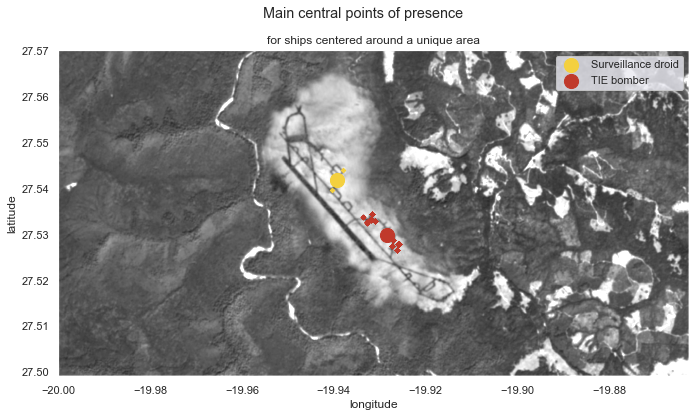

In [27]:
plt.figure(figsize=(12, 6))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

# Add ships centroids positions (corresponding to mean with low std)
for ship in ma_centroid.index:
    # Centroid
    x = ma_centroid['lon']['mean'].loc[ship]
    y = ma_centroid['lat']['mean'].loc[ship]
    color = ship_color_table[ship]
    plt.scatter([x], [y], label=ship, s=200, c=color)

    # Corresponding ships positions
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=10, marker='D')


plt.suptitle('Main central points of presence')
plt.title('for ships centered around a unique area')
plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

#### Centroids for all the ships positions

In [28]:
def recalculate_clusters(X, centroids, k):
    """ Recalculates the clusters """
    # Initiate empty clusters
    clusters = {}
    # Set the range for value of k (number of centroids)
    for i in range(k):
        clusters[i] = []
    for x in X.values:
        euc_dist = []
        for j in range(k):
            euc_dist.append(np.linalg.norm(x - centroids[j]))
        # Append the cluster of x to the dictionary
        clusters[euc_dist.index(min(euc_dist))].append(x)
    return clusters

def recalculate_centroids(centroids, clusters, k):
    """ Recalculates the centroid position based on the plot """
    for i in range(k):
        centroids[i] = np.average(clusters[i], axis=0)
    return centroids

In [29]:
# Init centroids
X = data[['lon', 'lat']]

K = 2
clusters2 = {}
for i in range(K):
    clusters2[i] = []

centroids2 = {}
for i in range(K):
    centroids2[i] = X.iloc[i]

clusters2 = recalculate_clusters(X=X, centroids=centroids2, k=K)
centroids2 = recalculate_centroids(centroids=centroids2, clusters=clusters2, k=K)

In [30]:
# Iterate multiple times to make centroids converge
for i in range(2):
    clusters2 = recalculate_clusters(X=X, centroids=centroids2, k=K)
    centroids2 = recalculate_centroids(centroids=centroids2, clusters=clusters2, k=K)

centroids2

{0: array([-19.94704827,  27.55104366]),
 1: array([-19.92310965,  27.52448261])}

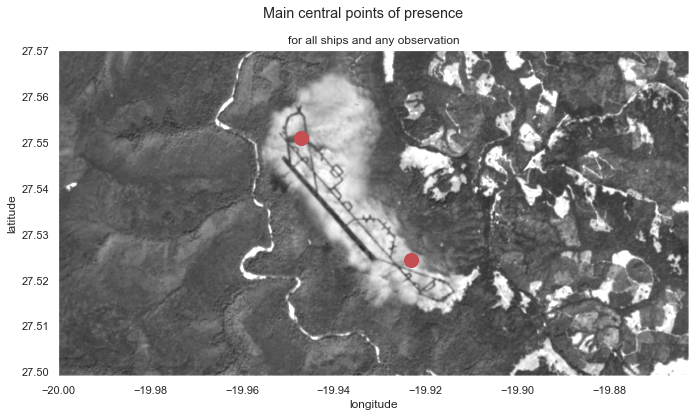

In [31]:
plt.figure(figsize=(12, 6))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

# Add ships centroids positions (computed using kmeans)
for i in centroids2:
    plt.scatter(centroids2[i][0], centroids2[i][1], c='r', s=200)

plt.suptitle('Main central points of presence')
plt.title('for all ships and any observation')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

#### Find ships having 2 centroids using kmeans

In [32]:
def kmeans(X, k, ship=None, n_iter=10):
    """ Compute centroids using kmeans algorithm """
    ma_ship = X['ship_type'] == ship
    X = X[ma_ship]
    X = X[['lon', 'lat']]

    clusters = {}
    for i in range(k):
        clusters[i] = []

    centroids = {}
    for i in range(k):
        centroids[i] = X.iloc[i]

    for i in range(n_iter):
        clusters = recalculate_clusters(X=X, centroids=centroids, k=k)
        centroids = recalculate_centroids(centroids=centroids, clusters=clusters, k=k)

    return centroids

In [33]:
centroids = {} 
# ship = 'Surveillance droid'
X = data.copy()
for ship in ship_types:
    centroids[ship] = kmeans(X=X, k=2, ship=ship)

In [34]:
# Keep only centroids that are enough spread on the map
spread_ships = []

for ship in ship_types:
    std = np.std(list(centroids[ship].values()), axis=0)
    mean_std = np.mean(std)
    if mean_std > .003:
        print(mean_std)
        spread_ships.append(ship)

0.008072902397262105
0.009269054687198519
0.015571843801279961


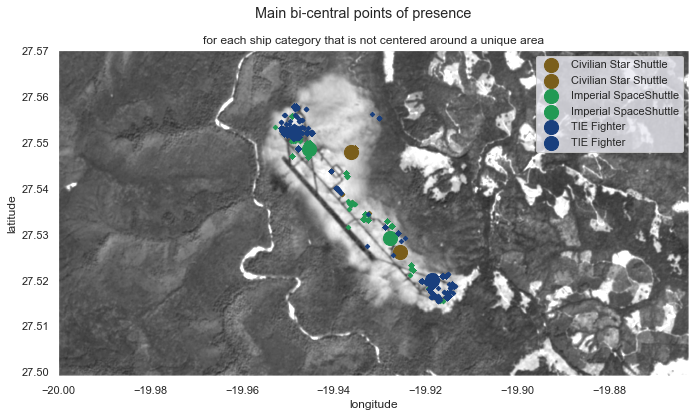

In [35]:
plt.figure(figsize=(12, 6))
# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

# Add ships centroids positions (computed using kmeans)
for ship in spread_ships:
    color = ship_color_table[ship]
    for i in centroids[ship]:
        plt.scatter(centroids[ship][i][0], centroids[ship][i][1], c=color, s=200, label=ship)

    # Corresponding ships positions
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=10, marker='D')

plt.suptitle('Main bi-central points of presence')
plt.title('for each ship category that is not centered around a unique area')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()

plt.show()

- Improve by displaying centroids only for ships that need 2 centroids (i.e. not the green)

## Decommissioned vehicles
Hyp: it can't be the same exact position by chance, so it is the same ship

In [36]:
dup_pos = data[['lon', 'lat']].duplicated()
sum(dup_pos)

260

In [37]:
static = data[dup_pos][['lon', 'lat']].value_counts()

In [38]:
static = static.reset_index()
static.rename(columns={0: 'count'}, inplace=True)

In [39]:
ma_static_short = static['count'] < 3
static_short = static[ma_static_short]
static_short

,lon,lat,count
4,-19.927388,27.527467,2
5,-19.945698,27.546897,2
6,-19.948944,27.551062,2
7,-19.918854,27.518498,2
8,-19.917137,27.516160,2
...,...,...,...
218,-19.947664,27.551143,1
219,-19.947664,27.551145,1
220,-19.947662,27.551143,1
221,-19.947662,27.551145,1


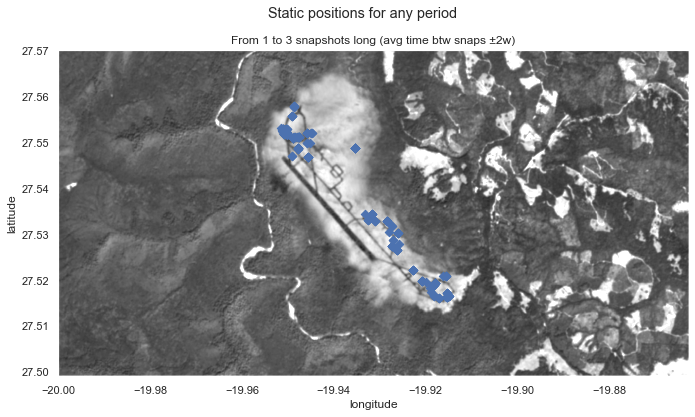

In [40]:
plt.figure(figsize=(12, 6))

# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

for lon, lat in zip(static['lon'], static['lat']):
    plt.scatter(lon,lat, c='b', marker='D')

plt.suptitle('Static positions for any period')
plt.title('From 1 to 3 snapshots long (avg time btw snaps ±2w)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

- Many ships static for 1 and 2 periods (219)
- Spread almost everywhere, excepted in what seems to be a runway and on the paths to it
- More precisely, there are 3 parking areas

In [41]:
ma_static_long = static['count']>2
static_long = static[ma_static_long]
static_long

,lon,lat,count
0,-19.915599,27.520862,3
1,-19.914900,27.516619,3
2,-19.915460,27.516336,3
3,-19.935360,27.548824,3


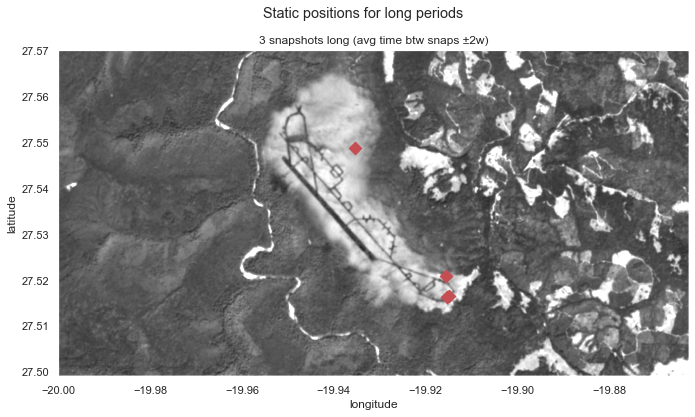

In [42]:
plt.figure(figsize=(12, 6))

# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

for lon, lat in zip(static_long['lon'], static_long['lat']):
    plt.scatter(lon,lat, c='r', marker='D', s=80)

plt.suptitle('Static positions for long periods')
plt.title('3 snapshots long (avg time btw snaps ±2w)')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

- Four points on a long static journey:
    - 1 appart in the field
    - 3 at one extreme of the spaceport

### Lon vs lat static

In [43]:
lon_static = data[dup_pos]['lon'].value_counts()
lat_static = data[dup_pos]['lat'].value_counts()
print('lon', lon_static.shape)
print('lat', lat_static.shape)

lon (185,)
lat (164,)


- These duplicates confirm that some vehicules have been static on more or less long periods
- Be careful since there are more static lon than lat.
    - It may be due to noisy detection on the lon / lat
        - Inspect if close lat for a same lon
        - Inspect if a lat has slipped during a long static period (that continues after)
- Are the static vehicules only some ship types?

In [44]:
# How long between two snapshots?
n_days_3_y = 365*3
n_snapshots = data['date'].nunique()
days_btw_snaps = n_days_3_y / n_snapshots
round(days_btw_snaps)

15

- Snapshots are taken on average every two weeks
- Thus, if a vehicule remained static between only 2 dates, it has actually been static [2w; 3w[
- And +4w for 3 dates and more
- weeks_static = (n_dates - 1) * 2
- since some remained static 5 dates, it was decommissioned 8w (2 months)

### Are they static around the same area?

#### For long static periods (+3 dates)

In [45]:
x_static = lon_static[lon_static >= 3]
y_static = lat_static[lat_static >= 3]
x_static = x_static.index
y_static = y_static.index

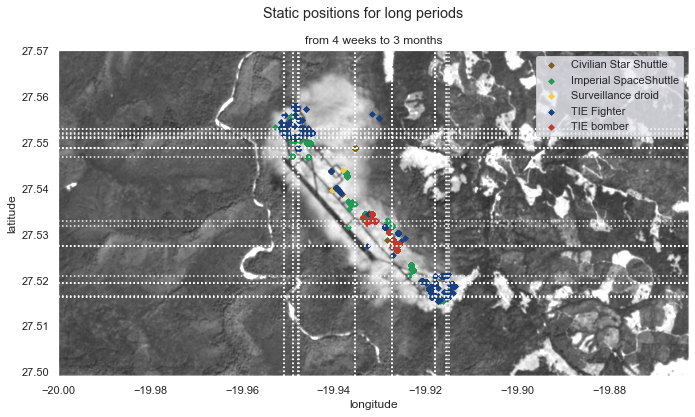

In [46]:
plt.figure(figsize=(12, 6))

# Draw background
plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 

for ship, color in ship_color_table.items():
    ma_ship_type = data['ship_type'] == ship
    plt.scatter(data[ma_ship_type]['lon'], data[ma_ship_type]['lat'], c=color, s=15, marker='D', label=ship)

# Add specific positions
for x in x_static:
    plt.vlines(x, y_min, y_max, colors='w', linestyles='dotted')
for y in y_static:
    plt.hlines(y, x_min, x_max, colors='w', linestyles='dotted')

plt.suptitle('Static positions for long periods')
plt.title('from 4 weeks to 3 months')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.show()

- Ships are statics for long periods mainly on the sides

### Are these static ships concerning certain categories only?

In [47]:
dup_pos = data[['lon', 'lat']].duplicated()
lon_static = data[dup_pos][['lon', 'ship_type']].value_counts().reset_index()
lat_static = data[dup_pos][['lat', 'ship_type']].value_counts().reset_index()

In [48]:
static_type = lon_static.groupby('ship_type').sum()
static_type = static_type.rename(columns=({0:'n_static_periods'}))
static_type

,lon,n_static_periods
ship_type,,
Civilian Star Shuttle,-159.482842,14
Imperial SpaceShuttle,-618.070491,37
TIE Fighter,-2452.068319,177
TIE bomber,-458.354802,32


In [49]:
counts_ship_type = data['ship_type'].value_counts()
counts_ship_type.name = 'total_ships_for_the_type'
counts_ship_type

TIE Fighter              2034
Imperial SpaceShuttle     827
TIE bomber                511
Civilian Star Shuttle      89
Surveillance droid          2
Name: total_ships_for_the_type, dtype: int64

In [50]:
static_type_pct_df = pd.merge(static_type, counts_ship_type, left_index=True, right_index=True)
pct = static_type_pct_df['n_static_periods'] / static_type_pct_df['total_ships_for_the_type']
pct

Civilian Star Shuttle    0.157303
Imperial SpaceShuttle    0.044740
TIE Fighter              0.087021
TIE bomber               0.062622
dtype: float64

- The Civilian Star Shuttle is the most static ship! with 15.7%
- The Imperial Space Shuttle is the most dynamic, being static 4% of the time
- The others are static about 7% of the time

In [51]:
pct = pct*100

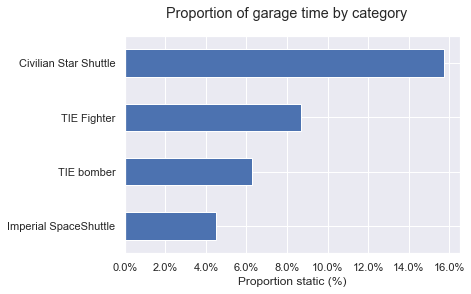

In [52]:
pct.sort_values(ascending=True, inplace=True)
ax = pct.plot.barh()
plt.suptitle('Proportion of garage time by category')
plt.xlabel('Proportion static (%)')

ax.xaxis.set_major_formatter(mtick.PercentFormatter())

- These numbers do not take into account the noise in positions
- Correct the noise and compute again these numbers
- The droid do not appear since it was present only twice (at different positions)

### Consider static within a close area (remove noise)

- Rounding at 6 rounds the last digit, even though it does not explicitly reduce the precision

In [53]:
THRESHOLD = 6  # as a float precision parameter

In [54]:
def smooth(data, threshold):
    smooth = data.copy()
    smooth['lon'] = round(smooth['lon'], threshold)
    smooth['lat'] = round(smooth['lat'], threshold)
    return smooth

In [55]:
def compute_prop(data, threshold):
    dup_pos = data[['lon', 'lat']].duplicated()
    lon_static = data[dup_pos][['lon', 'ship_type']].value_counts().reset_index()
    lat_static = data[dup_pos][['lat', 'ship_type']].value_counts().reset_index()

    static_type = lon_static.groupby('ship_type').sum()
    static_type = static_type.rename(columns=({0:'n_static_periods'}))

    static_type_pct_df = pd.merge(static_type, counts_ship_type, left_index=True, right_index=True)
    pct = static_type_pct_df['n_static_periods'] / static_type_pct_df['total_ships_for_the_type']
    pct = pct*100
    return pct

In [56]:
def plot_prop(data, threshold):
    plt.figure(figsize=(7, 5))
    data.sort_values(ascending=True, inplace=True)
    ax = data.plot.barh()
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.title(f'Using threshold {threshold} (±float precision)')
    plt.suptitle('Proportion of time static by category')
    plt.xlabel('Proportion static (%)')
    plt.show()

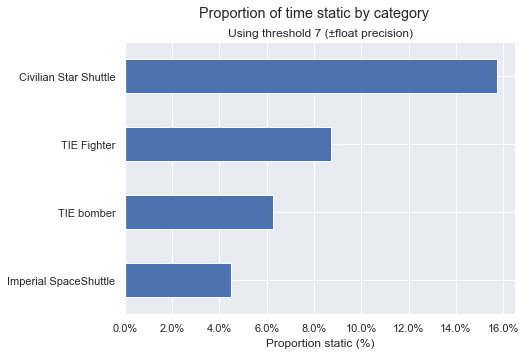

In [57]:
THRESHOLD = 7
data_smooth = smooth(data, threshold=THRESHOLD)
prop = compute_prop(data_smooth, threshold=THRESHOLD)
plot_prop(prop, threshold=THRESHOLD)

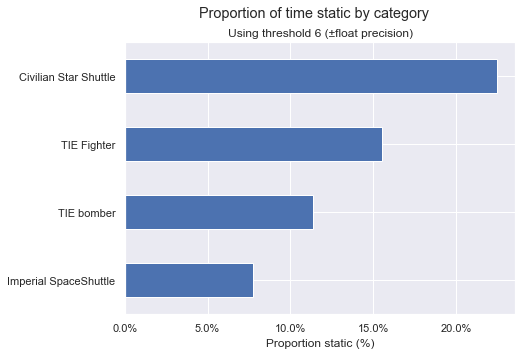

In [58]:
THRESHOLD = 6
data_smooth = smooth(data, threshold=THRESHOLD)
prop = compute_prop(data_smooth, threshold=THRESHOLD)
plot_prop(prop, threshold=THRESHOLD)

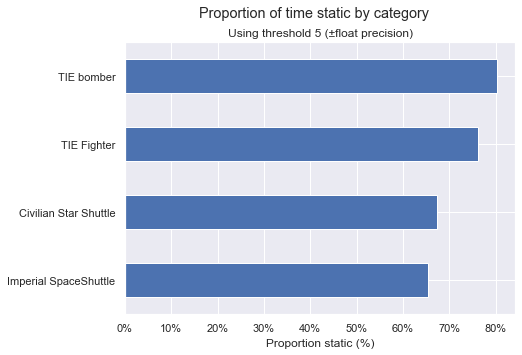

In [59]:
THRESHOLD = 5
data_smooth = smooth(data, threshold=THRESHOLD)
prop = compute_prop(data_smooth, threshold=THRESHOLD)
plot_prop(prop, threshold=THRESHOLD)

- Is 5 closer to reality than 6 (i.e. are ships mostly static?)
- To answer this question, one needs to know:
    - the precision of detections
    - (expert) whether this precision makes sense in terms of latitude and longitude

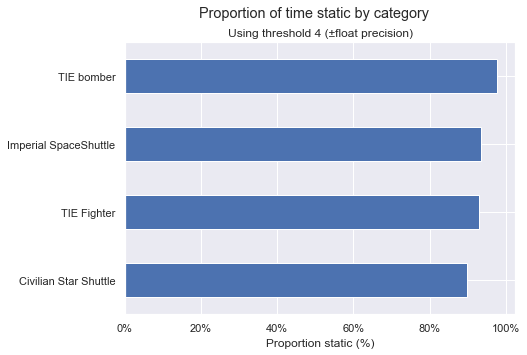

In [60]:
THRESHOLD = 4
data_smooth = smooth(data, threshold=THRESHOLD)
prop = compute_prop(data_smooth, threshold=THRESHOLD)
plot_prop(prop, threshold=THRESHOLD)

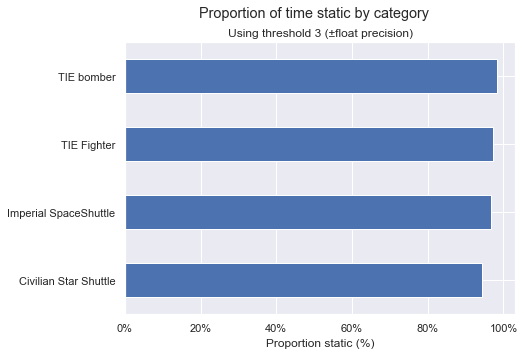

In [61]:
THRESHOLD = 3
data_smooth = smooth(data, threshold=THRESHOLD)
prop = compute_prop(data_smooth, threshold=THRESHOLD)
plot_prop(prop, threshold=THRESHOLD)

## Visualize snapshots over time

#### Each snapshot one after the other, optional filter by type

In [62]:
snapshots = [data[data['date']==date] for date in data['date'].unique()]

In [63]:
%%script echo cell_skipped

for i, snap in enumerate(snapshots):
    clear_output(wait=True)
    print('date:', i, snap['date'].iloc[0])
    plt.figure(figsize=(12, 6))
    plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 
    
    # plt.scatter(snap['lon'], snap['lat'], c='r')
    for ship, color in ship_color_table.items():
        ma_ship_type = snap['ship_type'] == ship
        plt.scatter(snap[ma_ship_type]['lon'], snap[ma_ship_type]['lat'], c=color, s=25, marker='D', label=ship)

    plt.suptitle('Starships positions over time')
    title = f"date: {i} {snap['date'].iloc[0]}"
    plt.title(title)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    time.sleep(2)
    if i > 3:
        break

cell_skipped


#### Create gif

In [64]:
%%script echo cell_skipped

filenames = []
for i, snap in enumerate(snapshots):
    clear_output(wait=True)
    print('\rdate:', i, snap['date'].iloc[0])
    
    plt.figure(figsize=(12, 6))
    plt.imshow(img_arr, zorder=.5, cmap='gray', vmin=0, vmax=180, extent=raster.extent) 
    
    # plt.scatter(snap['lon'], snap['lat'], c='r')
    for ship, color in ship_color_table.items():
        ma_ship_type = snap['ship_type'] == ship
        plt.scatter(snap[ma_ship_type]['lon'], snap[ma_ship_type]['lat'], c=color, s=25, marker='D', label=ship)
    
    # Add info
    plt.suptitle('Starships positions over time')
    title = f"date: {i} {snap['date'].iloc[0]}"
    plt.title(title)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.legend(bbox_to_anchor=(1, 1))

    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()

# build gif
with imageio.get_writer('data/starships_anim.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

print("Gif successfully created")

cell_skipped
